In [ ]:
import langchain    
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import re



In [ ]:
os.environ["GOOGLE_API_KEY"] = "UR API KEY HERE"
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)

# --- Dynamically build the prompt ---
prompt_parts = "Hi how are you? " \
               "Can you tell me a joke about computers? " \
                "Make it short and funny."

message = HumanMessage(content=prompt_parts)
response = llm.invoke([message])

In [26]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a creative writing assistant."),
    ("user", """Please paraphrase this text in the style of {style}:

{text}""")
])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

style_chain = (
    {
        "text": lambda x: clean_text(x["text"]),  # Extract and clean the text from input dict
        "style": lambda x: x["style"]  # Extract style from input dict
    }
    | prompt  # Format with our template
    | llm  # Generate creative paraphrase
    | StrOutputParser()  # Convert to string
)
response = style_chain.invoke(
    {"text": "The quick brown fox jumps over the lazy dog.", "style": "Shakespearean"}
)   

In [27]:
response

"Hark! The nimble fox, with pelt of ruddy brown,\nDoth lightly leap o'er yonder sluggish hound."

In [14]:
import numexpr
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda

# Create a function to handle calculations
def calculate(expression: str) -> str:
    try:
        result = float(numexpr.evaluate(expression))
        return f"The result is: {result}"
    except Exception as e:
        return f"Error in calculation: {str(e)}"

# Create the prompt
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful math assistant. When given a math problem, respond ONLY with the mathematical expression that would solve it. For example, if asked 'What is 2 raised to the 3rd power?', respond only with '2**3'."),
    ("user", "{question}")
])

# Wrap our calculation function with RunnableLambda for explicit LCEL pattern
calculate_runnable = RunnableLambda(calculate)

# Create the chain using LCEL with explicit RunnableLambda
math_chain = (
    prompt
    | llm  # Language model to interpret the prompt
    | StrOutputParser()  # Convert to string
    | calculate_runnable  # Our calculation function wrapped in RunnableLambda
)

# Use the chain with our example
response = math_chain.invoke({
    "question": "What is 13 raised to the .3432 power?"
})
print(response)

The result is: 2.4116004626599237


In [ ]:
import math
from typing import Annotated, Sequence
import numexpr
from langchain_core.messages import BaseMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt.tool_node import ToolNode
from typing_extensions import TypedDict
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_google_genai import ChatGoogleGenerativeAI

# ---------------------- Calculator Tool ----------------------
@tool
def calculator(expression: str) -> str:
    """Calculate expression using Python's numexpr library.

    Expression should be a single line mathematical expression
    that solves the problem.

    Examples:
        "37593 * 67" for "37593 times 67"
        "37593**(1/5)" for "37593^(1/5)"
    """
    local_dict = {"pi": math.pi, "e": math.e}
    return str(
        numexpr.evaluate(
            expression.strip(),
            global_dict={},  # restrict access to globals
            local_dict=local_dict,  # add common mathematical functions
        )
    )

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.7
)

search_tool = DuckDuckGoSearchRun()

tools = [calculator, search_tool]
llm_with_tools = llm.bind_tools(tools, tool_choice="any")

class ChainState(TypedDict):
    """LangGraph state."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

async def acall_chain(state: ChainState, config: RunnableConfig):
    response = await llm_with_tools.ainvoke(state["messages"], config)
    return {"messages": [response]}

async def acall_model(state: ChainState, config: RunnableConfig):
    response = await llm.ainvoke(state["messages"], config)
    return {"messages": [response]}

graph_builder = StateGraph(ChainState)
graph_builder.add_node("call_tool", acall_chain)
graph_builder.add_node("execute_tool", ToolNode(tools))
graph_builder.add_node("call_model", acall_model)

graph_builder.set_entry_point("call_tool")
graph_builder.add_edge("call_tool", "execute_tool")
graph_builder.add_edge("execute_tool", "call_model")
graph_builder.add_edge("call_model", END)

chain = graph_builder.compile()


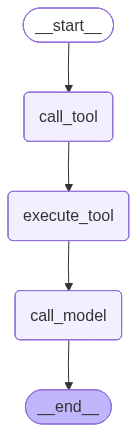

In [43]:
# Visualize chain:

from IPython.display import Image

Image(chain.get_graph().draw_mermaid_png())

In [50]:
# Stream chain steps:

system_prompt = """
You are a helpful assistant with access to a calculator tool and a search tool.
Only use the calculator tool when the user is asking a MATH question.
"""

example_query = "How to start a business?"

events = chain.astream(
    {"messages": [("system", system_prompt), ("user", example_query)]},
    stream_mode="values",
)
async for event in events:
    event["messages"][-1].pretty_print()



================================ Human Message =================================

How to start a business?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (867128a9-b5db-419a-8090-965ad0c364f2)
 Call ID: 867128a9-b5db-419a-8090-965ad0c364f2
  Args:
    query: how to start a business
================================= Tool Message =================================
Name: duckduckgo_search

September 17, 2025 - This guide was reviewed by a Business ... Editorial Guidelines. Starting a business can be hard work, but breaking down the process of launching your new venture into individual steps can make it easier .... Best Businesses to Start in Washington, ... its goals and what’s required to meet those goals. You’ll need a detailed business plan if you will be applying for a business loan or looking for a loan .... Learn how to start a business and set up a company successfully. Explore the best way to launch a small online bu

In [51]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

sentiment_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a sentiment analysis expert. Analyze the emotional tone."),
    ("user", "What's the sentiment of: {text}")
])

summary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a summarization expert."),
    ("user", "Summarize in one sentence: {text}")
])

analysis_chain = RunnableParallel(
    {
        "sentiment": sentiment_prompt | llm | StrOutputParser(),
        "summary": summary_prompt | llm | StrOutputParser(),
        "original": RunnablePassthrough()  # Pass through the original input
    }
)

sample_text = {"text": "The product exceeded my expectations. Great quality!"}
results = analysis_chain.invoke(sample_text)

print("Sentiment:", results["sentiment"])
print("Summary:", results["summary"])
print("Original:", results["original"]["text"])

Sentiment: The sentiment is **strongly positive**.

Both phrases clearly indicate a highly favorable experience:
*   "exceeded my expectations" implies the product performed better than anticipated, leading to satisfaction or delight.
*   "Great quality!" is an explicit and enthusiastic positive endorsement.
Summary: The product's great quality exceeded expectations.
Original: The product exceeded my expectations. Great quality!


In [ ]:
qa_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant. Answer correctly."),
    ("user", "{question}")
])

qa_chain = qa_prompt | llm | StrOutputParser()

questions = [
    {"question": "What is the capital of France?"},
    {"question": "Who wrote Romeo and Juliet?"},
    {"question": "What is the speed of light?"}
]
answers = qa_chain.batch(questions)
for q, a in zip(questions, answers):
    print(f"Q: {q['question']}")
    print(f"A: {a}\n")

Q: What is the capital of France?
A: Paris

Q: Who wrote Romeo and Juliet?
A: William Shakespeare.

Q: What is the speed of light?
A: Approximately 299,792,458 meters per second in a vacuum.



In [ ]:
# using memory
demo_ephemeral_chat_history = [
    HumanMessage(content="Hey there! I'm Nemo."),
    AIMessage(content="Hello!"),
    HumanMessage(content="How are you today?"),
    AIMessage(content="Fine thanks!"),
]
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a friendly assistant."),
    ("user", "{messages}")
])

chain = prompt | llm | StrOutputParser()

chain.invoke(
    {"messages": demo_ephemeral_chat_history + [HumanMessage(content="What's my name?")]}
)


'Your name is Nemo!'